In [1]:
import pandas as pd
import os
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import pickle
import gensim.downloader
from gensim.models import Word2Vec
import random

In [2]:
DATA_FOLDER = 'data/balanced'
MODEL_FOLDER = 'models'
EXPERIMENT_FOLDER = 'experiment'

VALUES = ['ACHIEVEMENT', 'BENEVOLENCE', 'CONFORMITY', 'HEDONISM', 'POWER', 'SECURITY', 'SELF-DIRECTION', 'STIMULATION', 'TRADITION', 'UNIVERSALISM']


In [3]:
with open("./train_test_data/X_test.pkl", 'rb') as file:
    X_test = pickle.load(file)
with open("./train_test_data/X_train.pkl", 'rb') as file:
    X_train = pickle.load(file)
with open("./train_test_data/y_test.pkl", 'rb') as file:
    y_test = pickle.load(file)
with open("./train_test_data/y_train.pkl", 'rb') as file:
    y_train = pickle.load(file)

In [4]:
y_test, X_test = y_test.loc[~(y_test["label"] == 0)], X_test.loc[~(y_test["label"] == 0)]
y_train, X_train = y_train.loc[~(y_train["label"] == 0)], X_train.loc[~(y_train["label"] == 0)]


In [5]:
y_test['new_value'] = np.where(y_test['label'] == -1, 'NOT_' + y_test['value'], y_test['value'])

y_train['new_value'] = np.where(y_train['label'] == -1, 'NOT_' + y_train['value'], y_train['value'])

#dataset['new_value'] = np.where(dataset['label'] == -1, 'NOT_' + dataset['value'], dataset['value'])

In [6]:
y_test.head()

,label,value,new_value
3324,-1,BENEVOLENCE,NOT_BENEVOLENCE
1880,-1,BENEVOLENCE,NOT_BENEVOLENCE
4960,-1,BENEVOLENCE,NOT_BENEVOLENCE
322,-1,HEDONISM,NOT_HEDONISM
2763,-1,SECURITY,NOT_SECURITY


In [7]:

count_vect = CountVectorizer()
tf_vect = TfidfVectorizer()
count_vect.fit(pd.concat([X_train, X_test]))
X_train = count_vect.transform(X_train).toarray()
X_test = count_vect.transform(X_test).toarray()


In [8]:
y_train = y_train["new_value"]
y_test = y_test["new_value"]


In [9]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11643, 9155) (2904, 9155) (11643,) (2904,)


In [10]:
X_train = np.array([np.array(sublist) for sublist in X_train])
y_train = np.array([np.array(sublist) for sublist in y_train])
X_test = np.array([np.array(sublist) for sublist in X_test])
y_test = np.array([np.array(sublist) for sublist in y_test])


In [11]:
y_test

array(['NOT_BENEVOLENCE', 'NOT_BENEVOLENCE', 'NOT_BENEVOLENCE', ...,
       'HEDONISM', 'HEDONISM', 'NOT_HEDONISM'], dtype='<U18')

In [12]:
mapping_dict = {
    'POWER': 0,
    'NOT_POWER': 1,
    'BENEVOLENCE': 2,
    'NOT_BENEVOLENCE': 3,
    'SECURITY': 4,
    'NOT_SECURITY': 5,
    'HEDONISM': 6,
    'NOT_HEDONISM': 7,
    'UNIVERSALISM': 8,
    'NOT_UNIVERSALISM': 9,
    'STIMULATION': 10,
    'NOT_STIMULATION': 11,
    'CONFORMITY': 12,
    'NOT_CONFORMITY': 13,
    'ACHIEVEMENT': 14,
    'NOT_ACHIEVEMENT': 15,
    'SELF-DIRECTION': 16,
    'NOT_SELF-DIRECTION': 17,
    'TRADITION': 18,
    'NOT_TRADITION': 19   
}


In [13]:
y_train_number = np.array([mapping_dict[item] for item in y_train])
y_test_number = np.array([mapping_dict[item] for item in y_test])

In [79]:
# GMM = GaussianMixture(n_components=20)

# GMM.fit(X_train, y_train_number)

naive_bayse = MultinomialNB(force_alpha=False)

naive_bayse.fit(X_train, y_train_number)


In [39]:

y_pred = naive_bayse.predict(X_test)
print(y_pred)
# Evaluate the classifier
accuracy = accuracy_score(y_test_number, y_pred)
conf_matrix = confusion_matrix(y_test_number, y_pred)
#f1 = f1_score(y_test_number, y_pred)
class_report = classification_report(y_test_number, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
#print(f'F1 score: {f1}')

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

[3 3 3 ... 3 3 3]
Accuracy: 0.32300275482093666
Confusion Matrix:
[[  0   0   0  78   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0  52   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0 180   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0 932   0   1   0   0   0   0   0   0   0   1   0   0   0   0
    0   0]
 [  0   0   0 120   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0]
 [  0   0   0 291   0   2   0   0   0   0   0   0   0   1   0   0   0   0
    0   0]
 [  0   0   0 158   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0 105   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0  46   0   1   0   0   0   0   0   0   0   1   0   0   0   0
    0   0]
 [  0   0   0 144   0   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]

C:\Users\pierr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pierr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pierr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

In [20]:
def plot_class_accuracies(conf_matrix, classes, title='Class Accuracies', cmap=plt.cm.Blues):
    # Calculate accuracies for each class
    class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

    # Plot the accuracies
    plt.figure(figsize=(10, 6))
    plt.bar(classes, class_accuracies)
    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [22]:
classes =[
    'POWER',
    'NOT_POWER',
    'BENEVOLENCE',
    'NOT_BENEVOLENCE',
    'SECURITY',
    'NOT_SECURITY',
    'HEDONISM',
    'NOT_HEDONISM',
    'UNIVERSALISM',
    'NOT_UNIVERSALISM',
    'STIMULATION',
    'NOT_STIMULATION',
    'CONFORMITY',
    'NOT_CONFORMITY',
    'ACHIEVEMENT',
    'NOT_ACHIEVEMENT',
    'SELF-DIRECTION',
    'NOT_SELF-DIRECTION',
    'TRADITION',
    'NOT_TRADITION'
]

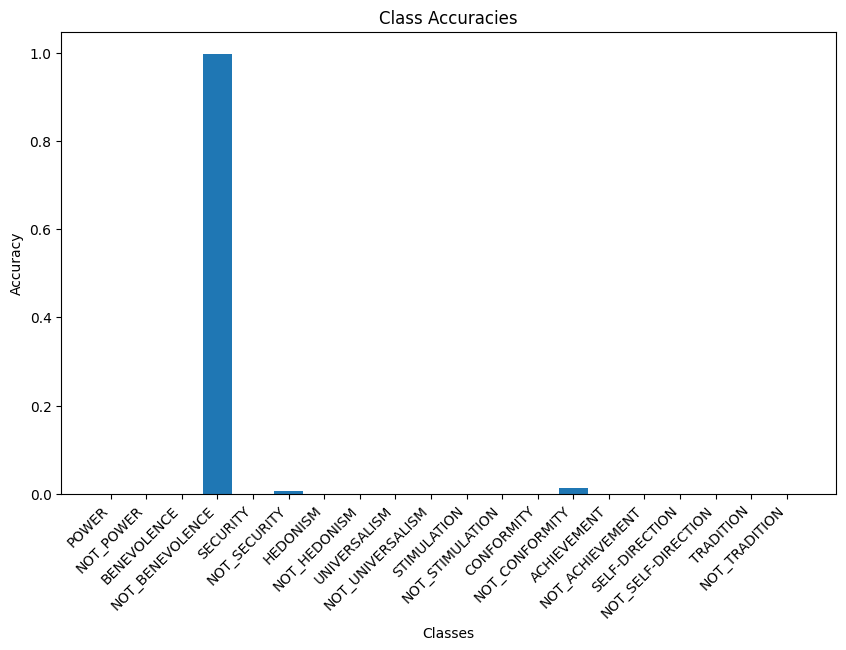

In [40]:
plot_class_accuracies(conf_matrix, classes, title='Class Accuracies')


In [14]:
def should_keep(x):
    return x != 3 or (x == 3 and random.randint(1, 100) < 50)

In [15]:
y_train_number

array([13,  4, 13, ...,  3,  3,  5])

In [16]:
# Identify rows where y_train is equal to 3
rows_keep_y = [should_keep(x) for x in y_train_number]


# # Keep all the rows where y_train is not equal to 3
filtered_y_train = y_train_number[rows_keep_y]
filtered_X_train = X_train[rows_keep_y]


In [17]:

naive_bayse = MultinomialNB(force_alpha=False)

naive_bayse.fit(filtered_X_train, filtered_y_train)

MultinomialNB(force_alpha=False)

In [18]:
y_pred = naive_bayse.predict(X_test)
print(y_pred)
# Evaluate the classifier
accuracy = accuracy_score(y_test_number, y_pred)
conf_matrix = confusion_matrix(y_test_number, y_pred)
#f1 = f1_score(y_test_number, y_pred)
class_report = classification_report(y_test_number, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
#print(f'F1 score: {f1}')

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

[ 3  3  3 ...  3 13  6]
Accuracy: 0.3488292011019284
Confusion Matrix:
[[  2   0   3  38   2  15   1   0   0   0   0   1   0  16   0   0   0   0
    0   0]
 [  3   0   0  29   0  13   2   0   0   0   0   1   0   5   0   0   0   0
    0   0]
 [  1   0  14 116   0  33   2   0   1   0   0   2   0  10   0   0   0   0
    0   1]
 [  0   0  10 726   1 125  11   0   0   6   0   3   0  46   1   1   0   0
    0   4]
 [  1   0   4  63   0  44   0   0   0   0   0   3   0   6   0   0   0   0
    0   0]
 [  2   0   3 142   2 120   3   0   0   2   0   0   0  17   0   1   0   0
    0   2]
 [  0   0   9  67   0  24  45   1   1   0   0   0   0  10   0   0   0   0
    0   1]
 [  0   0   2  70   0  15   9   3   0   1   0   2   0   3   0   0   0   0
    0   0]
 [  0   0   3  15   1  20   0   0   0   5   0   0   0   4   0   0   0   0
    0   0]
 [  2   0   2  75   2  34   0   0   0  13   0   0   0  16   0   0   0   0
    0   2]
 [  0   0   3  23   1  19   7   0   0   1   0   2   0   6   0   0   0   0
    0

C:\Users\pierr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pierr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pierr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

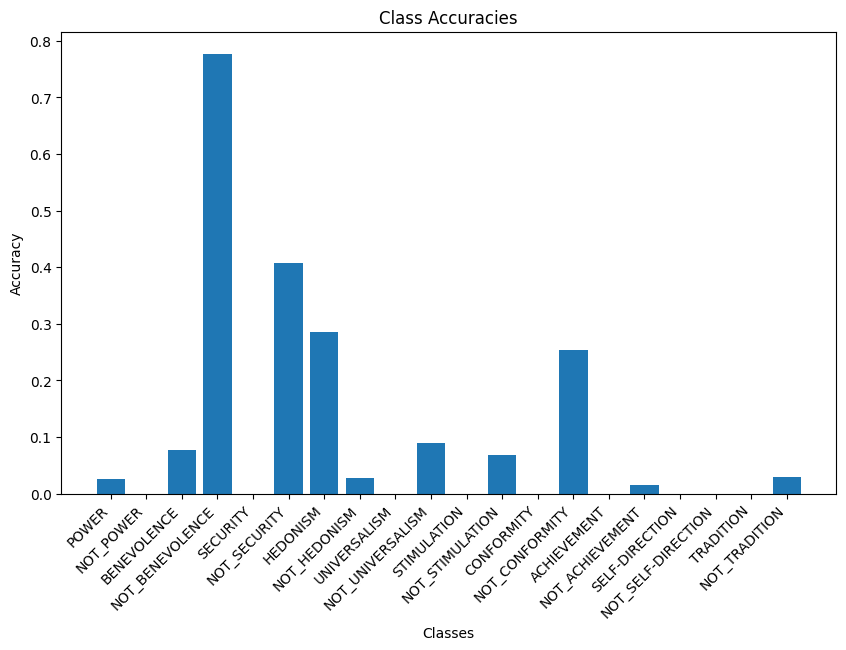

In [23]:
plot_class_accuracies(conf_matrix, classes, title='Class Accuracies')
